## Open Space Analysis

I was curious to work with public open space data because of the work of the Milton School Building Committee.

In recent public meetings, there has been much discussion of suitable sites in Milton for the construction of a new school.  Because
an RFP for the purchase of a suitable land parcel received no responses, the committee focused on currently open land owned by the Town of Milton,
restricting its searches to parcels of 6 acres or more.  It should be possible to identify all such parcels using the public open space dataset.

Additionally, Milton is famous for its extensive forests and trails, being nestled within the Blue Hills reservation.  I wanted to see if
this qualitative feature of life in Milton could be shown quantitatively in the open space data.  To achieve this, I compare the average
distance to the nearest open space parcel for residential land parcels in Milton vs Quincy, our significantly larger and more urban neighbor.  I wanted
to see if the average residential parcel is closer to open space in Milton than in Quincy.

In [1]:
import geopandas as gpd
import folium
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

import milton_maps as mm

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_context("notebook")

### Load cleaned and processed input files

This notebook works from cleaned and transformed data.  The transformation pipeline is defined in `dvc.yaml`.  To simply work with the latest version, pull the appropriate versions from dvc using `dvc pull`.  To regenerate the files, perhaps with local code changes, run `dvc repro`.

In [2]:
town_boundaries = gpd.read_file("../data/processed/town_boundaries.shp.zip").set_index("TOWN_ID")
milton_quincy_boundaries = town_boundaries[town_boundaries.TOWN.isin(["MILTON", "QUINCY"])]
milton_quincy_boundaries.shape

(2, 19)

In [3]:
openspace = gpd.read_file("../data/processed/openspace.shp.zip", mask=milton_quincy_boundaries)
openspace.shape

(416, 62)

In [4]:
residential_tax_parcels = joblib.load("../data/processed/residential_tax_parcels.pkl")
residential_tax_parcels.shape

(32387, 28)

### Data review

In order to contextualize the open space data maps, we'll plot them on top of the town boundary shapes for Milton and Quincy.  Load the town boundary data:

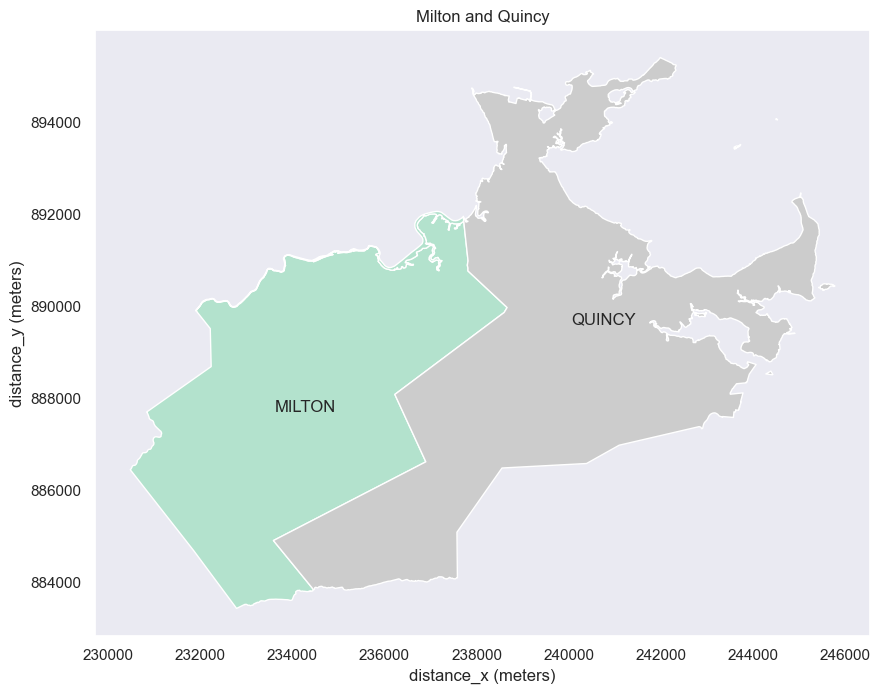

In [5]:
fig, ax = plt.subplots(1, figsize=(10,10))
mm.plot_map(milton_quincy_boundaries,
                 column="TOWN",
                 cmap="Pastel2",
                 title="Milton and Quincy",
                 legend=False,
                 ax=ax)
for i in milton_quincy_boundaries.index:
    x = town_boundaries.loc[[i]].representative_point().x
    y = town_boundaries.loc[[i]].representative_point().y
    plt.annotate(town_boundaries.loc[i, "TOWN"], (x,y))

plt.show()

#### Open space maps

Let's get a quick visualization of open spaces on our map of Milton and Quincy.  The following plot color codes the open spaces by the name of its
Manager.

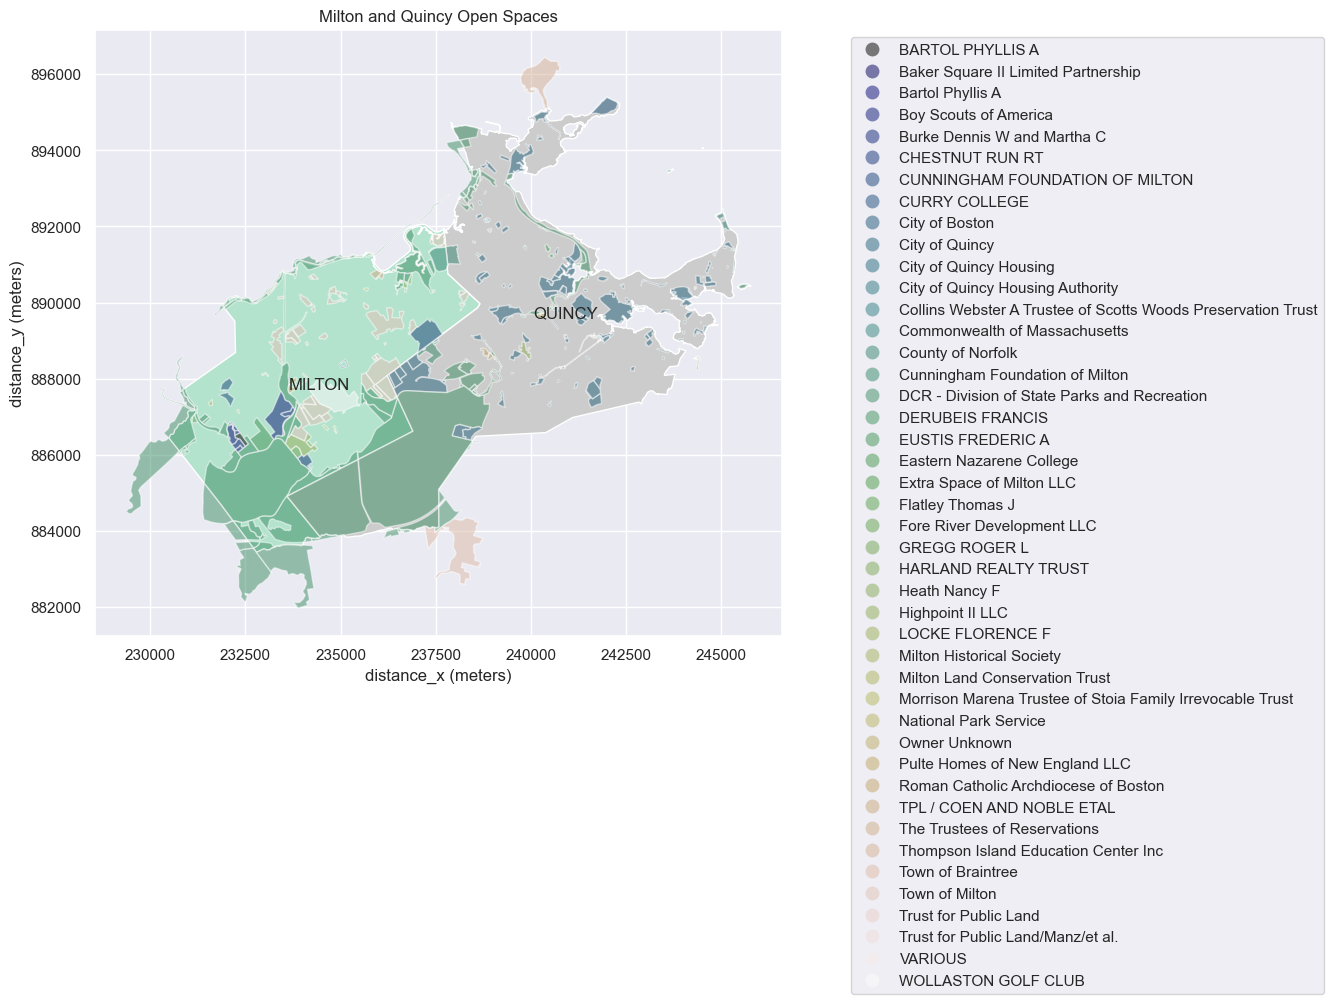

<Figure size 1500x800 with 0 Axes>

In [6]:
mm.plot_map(openspace,
            column="MANAGER",
            ax=ax,
            legend_shift=1.8,
            title="Milton and Quincy Open Spaces",
            alpha=0.5)
display(fig)

Now let's use the `folium` package to plot this data on top of an interactive street map.

In [7]:
map_center = milton_quincy_boundaries.dissolve().centroid.to_crs(epsg=4326)[0]

In [8]:
milton_map = folium.Map(width=800,height=800, location=[map_center.y, map_center.x], zoom_start=12)

sf, cm_dict = mm.make_choropleth_style_function(openspace, "PUB_ACCESS", "Dark2")

#Print a legend
display(Markdown("""**Explorable Map of Open Space**

You can pan and zoom the map below to explore open space in Quincy and Milton.
Click on open space parcels to see a pop-up with more information.
""" + mm.html_legend(cm_dict)))

folium.GeoJson(milton_quincy_boundaries.to_crs("EPSG:3857").geometry).add_to(milton_map)

# We need to convert the openspace geodataframe to the EPSG:3857 coordinate reference system (CRS) because that is the default for folium maps.
folium.GeoJson(data=openspace.to_crs("EPSG:3857"),
               style_function=sf,
               popup=folium.GeoJsonPopup(
                   fields=['SITE_NAME', 'MANAGER', 'GIS_ACRES', "PRIM_PURP", "PUB_ACCESS", "LEV_PROT"],
                   aliases=['Name','Managed by','Acres', "Primary Purpose", "Public Access", "Level of Protection"]
               )).add_to(milton_map)
display(milton_map)


**Explorable Map of Open Space**

You can pan and zoom the map below to explore open space in Quincy and Milton.
Click on open space parcels to see a pop-up with more information.
<table>
  <tr>
    <th>Value</th>
    <th>Color</th>
  </tr>
<tr><td><span style="font-family: monospace">Yes (open to public)</span></td> <td><span style="color: #1b9e77">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Limited (membership only)</span></td> <td><span style="color: #d95f02">████████</span></td></tr>
<tr><td><span style="font-family: monospace">No (not open to public)</span></td> <td><span style="color: #7570b3">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Unknown</span></td> <td><span style="color: #e7298a">████████</span></td></tr></table>

### Calculate distribution of distance to openspace for residential parcels

Finally, let's tackle our question of whether Quincy residents are further from open space on average compared to Milton residents.

Let's first filter the open space parcels down to those that are publicly accessible:

In [9]:
openspace['PUB_ACCESS'].unique()

array(['Yes (open to public)', 'Limited (membership only)',
       'No (not open to public)', 'Unknown'], dtype=object)

In [10]:
accessible_openspace = openspace[openspace['PUB_ACCESS']=="Yes (open to public)"]

The following geopandas spatial join links each residential land parcel to the nearest open space land parcel, using the closest distance between the two shapes.  It can produce multiple output rows per residential land parcel if there are multiple open space parcels that are equidistant with the shortest distance.

In [11]:
result = gpd.sjoin_nearest(residential_tax_parcels, accessible_openspace, how="left", distance_col="distance_to_openspace")
result.head()

SHAPE_Leng    SHAPE_Area MAP_PAR_ID POLY_TYPE MAP_NO  \
LOC_ID                                                                   
189M 2 6                 NaN           NaN        NaN       NaN    NaN   
2436080Q_22_22           NaN           NaN        NaN       NaN    NaN   
F_757603_2907021  718.018773  21213.803766    A 10 1B       FEE      A   
F_757603_2907021  718.018773  21213.803766    A 10 1B       FEE      A   
F_757686_2912486  234.162104   3303.047646     A 17 6       FEE      A   

                  SOURCE     PLAN_ID   LAST_EDIT BND_CHK NO_MATCH  ...  \
LOC_ID                                                             ...   
189M 2 6             NaN         NaN         NaN     NaN      NaN  ...   
2436080Q_22_22       NaN         NaN         NaN     NaN      NaN  ...   
F_757603_2907021  ASSESS      A-9-10  20180101.0    None        N  ...   
F_757603_2907021  ASSESS      A-9-10  20180101.0    None        N  ...   
F_757686_2912486   OTHER  A-15-16-17  20120120.0    None        N  ...   

                  INTSYM   OS_ID  CAL_DATE_R  FORMAL_SIT CR_REF OS_TYPE  \
LOC_ID                                                                    
189M 2 6             NaN     NaN         NaN         NaN    NaN     NaN   
2436080Q_22_22       NaN     NaN         NaN         NaN    NaN     NaN   
F_757603_2907021    None  189-91  2019-06-11        None    0.0    None   
F_757603_2907021    None  189-92  2019-06-11        None    0.0    None   
F_757686_2912486    None  189-28        None        None    0.0    None   

                 EEA_CR_ID    SHAPE_AREA    SHAPE_LEN  distance_to_openspace  
LOC_ID                                                                        
189M 2 6               NaN           NaN          NaN                    NaN  
2436080Q_22_22         NaN           NaN          NaN                    NaN  
F_757603_2907021      None   1218.553710   145.826404                    0.0  
F_757603_2907021      None   8290.233976   487.599831                    0.0  
F_757686_2912486      None  34775.779179  1491.197529                    0.0  

[5 rows x 91 columns]

Plot the distribution of distance to the nearest open land for Milton and for Quincy.

It looks like Quincy residents are just as close to the nearest open land as their Milton neighbors, on average.  That's a little surprising!

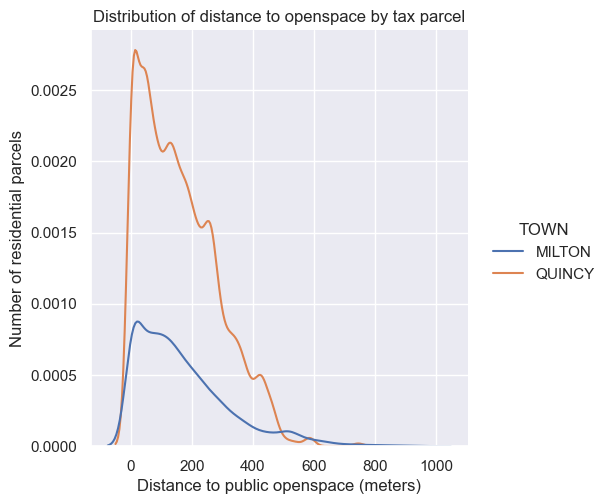

In [12]:
g = sns.displot(result.reset_index(), x='distance_to_openspace', hue="TOWN", kind="kde", common_norm=True)
g.set(xlabel="Distance to public openspace (meters)",
      ylabel="Number of residential parcels",
      title="Distribution of distance to openspace by tax parcel")
plt.show()

Quantifying htis in a table, we see the median Milton residence is 133 meters from the nearest open space, versus 139 meters for Quincy.  Not a big difference!

In [13]:
result.groupby("TOWN")["distance_to_openspace"].quantile([0.1,0.25,0.5,0.75,0.9, 1])

TOWN        
MILTON  0.10      5.712570
        0.25     53.941972
        0.50    133.926054
        0.75    243.333080
        0.90    379.553469
        1.00    972.307286
QUINCY  0.10     10.835055
        0.25     54.520340
        0.50    139.640397
        0.75    245.533747
        0.90    342.402368
        1.00    756.580150
Name: distance_to_openspace, dtype: float64

Can we find any quantitative metric that captures that Milton is a "greener" town than Quincy?  Yes, if we look at the sizes of the nearest open land, then we see a difference:

In [14]:
result.groupby("TOWN")["GIS_ACRES"].quantile([0.1,0.25,0.5,0.75,0.9, 1])

TOWN        
MILTON  0.10       1.202238
        0.25       2.840939
        0.50      10.360659
        0.75      41.058375
        0.90      91.141803
        1.00     850.270058
QUINCY  0.10       0.464241
        0.25       1.019486
        0.50       4.073247
        0.75       8.028349
        0.90      45.769913
        1.00    1753.275872
Name: GIS_ACRES, dtype: float64

While the median Milton residence is no closer to open space than its Quincy counterpart, the median acreage of that open plot is more than twice as large, 10 acres in Milton vs 4 acres in Quincy.

Another random question we can ask of this data: which specific open spaces are the nearest open spaces for the most residence?

In [15]:
result.groupby("SITE_NAME").agg(
    num_houses=('SITE_NAME', 'count'),
    median_distance=('distance_to_openspace', 'median'),
    acreage=('GIS_ACRES', 'max'),
).sort_values(by="num_houses", ascending=False)

num_houses  median_distance  \
SITE_NAME                                                                       
Neponset River Reservation                              1829        88.071413   
Furnace Brook Parkway                                   1377        56.429668   
Blue Hills Reservation                                  1285        89.716382   
Quincy Shore Reservation                                1102       129.058568   
Clifford H Marshall Elementary School Playground        1060       324.880118   
...                                                      ...              ...   
Beechwood Knoll School Playground                         11        43.317348   
Jean Kennedy Playground                                    9       112.574221   
Lamb Conservation Area                                     5       234.870044   
Brooks Field                                               3        58.219847   
Front - Heron Beach                                        2        38.887931   

                                                      acreage  
SITE_NAME                                                      
Neponset River Reservation                         109.972767  
Furnace Brook Parkway                               13.560602  
Blue Hills Reservation                            1753.275872  
Quincy Shore Reservation                            70.234147  
Clifford H Marshall Elementary School Playground     2.298916  
...                                                       ...  
Beechwood Knoll School Playground                    0.198522  
Jean Kennedy Playground                              0.158380  
Lamb Conservation Area                               7.621469  
Brooks Field                                        14.741131  
Front - Heron Beach                                  0.380590  

[129 rows x 3 columns]

### School Building candidate parcels

The school building committee was looking at open spaces owned by the Town of Milton of at least 6 acres.  Can we see how many of these there are and where they're located?

In [16]:
openspace.loc[openspace.FEE_OWNER.str.lower().str.contains("milton"), "FEE_OWNER"].unique()

array(['Town of Milton', 'Cunningham Foundation of Milton',
       'Milton Historical Society', 'CUNNINGHAM FOUNDATION OF MILTON',
       'Extra Space of Milton LLC', 'Milton Land Conservation Trust'],
      dtype=object)

In [17]:
school_site_candidates = openspace[(openspace.FEE_OWNER=="Town of Milton") & (openspace.GIS_ACRES >= 6.0)]
school_site_candidates

TOWN_ID  POLY_ID                            SITE_NAME       FEE_OWNER  \
100      189     3058   Milton High School Athletic Fields  Town of Milton   
101      189       58               Lamb Conservation Area  Town of Milton   
103      189     3131                         Brooks Field  Town of Milton   
105      189     3064                    Turners Pond Park  Town of Milton   
107      189     3132   Pine Tree Brook Flood Control Area  Town of Milton   
120      189     3046                   Milton Town Forest  Town of Milton   
121      189     3121                   Milton Town Forest  Town of Milton   
178      189       55                           Popes Pond  Town of Milton   
182      189       62            Granite Links Golf Course  Town of Milton   
183      189       60            Granite Links Golf Course  Town of Milton   
184      189       51         John L. Kelly Athletic Field  Town of Milton   
188      189     3049                                 None  Town of Milton   
208      189     3084                         Andrews Park  Town of Milton   
222      189     3047   Pine Tree Brook Flood Control Area  Town of Milton   
237      189     3123     Arrowhead Lane Conservation Area  Town of Milton   
243      189     3080  Collicot School & Mary A Cunningham  Town of Milton   
247      189     3116                                  Day  Town of Milton   
314      189     3073                      Milton Cemetery  Town of Milton   

    OWNER_ABRV OWNER_TYPE         MANAGER MANAGR_ABR MANAGR_TYP  \
100       M189          M  Town of Milton     M189SD          M   
101       M189          M  Town of Milton     M189CC          M   
103       M189          M  Town of Milton     M189CC          M   
105       M189          M  Town of Milton     M189PD          M   
107       M189          M  Town of Milton       None       None   
120       M189          M  Town of Milton       None       None   
121       M189          M  Town of Milton       None       None   
178       M189          M  Town of Milton     M189CC          M   
182       M189          M  Town of Milton       None          P   
183       M189          M  Town of Milton       None          P   
184       M189          M  Town of Milton     M189PD          M   
188       M189          M  Town of Milton     M189CC          M   
208       M189          M  Town of Milton     M189PD          M   
222       M189          M  Town of Milton       None       None   
237       M189          M  Town of Milton     M189CC          M   
243       M189          M  Town of Milton     M189SD          M   
247       M189          M  Town of Milton       None       None   
314       M189          M  Town of Milton       None       None   

                                            PRIM_PURP  ... INTSYM     OS_ID  \
100        Recreation (activities are facility based)  ...   None  189-3058   
101  Conservation (activities are non-facility based)  ...   None    189-58   
103        Recreation (activities are facility based)  ...   None  189-3131   
105        Recreation (activities are facility based)  ...   None  189-3064   
107                                     Flood Control  ...   None  189-3132   
120                                   Other (explain)  ...   None  189-3046   
121                                   Other (explain)  ...   None  189-3121   
178                       Recreation and Conservation  ...   None    189-55   
182        Recreation (activities are facility based)  ...   None    189-62   
183        Recreation (activities are facility based)  ...   None    189-60   
184        Recreation (activities are facility based)  ...   None    189-51   
188  Conservation (activities are non-facility based)  ...   None  189-3049   
208        Recreation (activities are facility based)  ...   None  189-3084   
222                                     Flood Control  ...   None  189-3047   
237  Conservation (activities are non-facility based)  ...   No

In [18]:
milton_boundaries = town_boundaries[town_boundaries.TOWN.isin(["MILTON"])]
map_center = milton_boundaries.dissolve().centroid.to_crs(epsg=4326)[0]

In [19]:
milton_map = folium.Map(width=800,height=800, location=[map_center.y, map_center.x], zoom_start=13)

sf, cm_dict = mm.make_choropleth_style_function(school_site_candidates, "PRIM_PURP", "Dark2")

#Print a legend
display(Markdown("""**Explorable Map of School Site Candidates**

You can pan and zoom the map below to explore school site candidates in Milton.
Click on open space parcels to see a pop-up with more information.
""" + mm.html_legend(cm_dict)))

folium.GeoJson(milton_boundaries.to_crs("EPSG:3857").geometry).add_to(milton_map)

# We need to convert the openspace geodataframe to the EPSG:3857 coordinate reference system (CRS) because that is the default for folium maps.
folium.GeoJson(data=school_site_candidates.to_crs("EPSG:3857"),
               style_function=sf,
               popup=folium.GeoJsonPopup(
                   fields=['SITE_NAME', 'GIS_ACRES', "PRIM_PURP", "PUB_ACCESS", "LEV_PROT", "COMMENTS"],
                   aliases=['Name','Managed by','Acres', "Primary Purpose", "Public Access", "Level of Protection"]
               )).add_to(milton_map)
display(milton_map)


**Explorable Map of School Site Candidates**

You can pan and zoom the map below to explore school site candidates in Milton.
Click on open space parcels to see a pop-up with more information.
<table>
  <tr>
    <th>Value</th>
    <th>Color</th>
  </tr>
<tr><td><span style="font-family: monospace">Recreation (activities are facility based)</span></td> <td><span style="color: #1b9e77">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Conservation (activities are non-facility based)</span></td> <td><span style="color: #d95f02">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Flood Control</span></td> <td><span style="color: #7570b3">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Other (explain)</span></td> <td><span style="color: #e7298a">████████</span></td></tr>
<tr><td><span style="font-family: monospace">Recreation and Conservation</span></td> <td><span style="color: #66a61e">████████</span></td></tr></table>

We can see that many town-owned parcels of the right size have existing recreational facilities or have a flood-control purpose and hence are not suitable for building.  The orange parcels are the remaining sites, and we can see that one of the remaining three is the much discussed Lamb Conservation Area.